In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [13]:
df = pd.read_csv("E:\Market Basket Analytics project\groceries.csv",header=None)
print(df.shape)

(9835, 32)


In [19]:
records = []
for i in range (0, 9835):
    records.append([str(df.values[i,j]) for j in range(0, 20)])
TE = TransactionEncoder()
array = TE.fit(records).transform(records)
#building the data frame rows are logical and columns are the items have been purchased 
df1 = pd.DataFrame(array, columns = TE.columns_)
df_clean = df1.drop(['nan'], axis = 1)
count = df_clean.loc[:,:].sum()
df2 = count.sort_values(0, ascending = False).head(20)
df2 = df2.to_frame()
df2 = df2.reset_index()
df2 = df2.rename(columns = {"index": "items",0: "count"})
df2.head(20)

,items,count
0,whole milk,2513
1,other vegetables,1903
2,rolls/buns,1808
3,soda,1713
4,yogurt,1372
5,bottled water,1086
6,root vegetables,1072
7,tropical fruit,1032
8,shopping bags,968
9,sausage,924


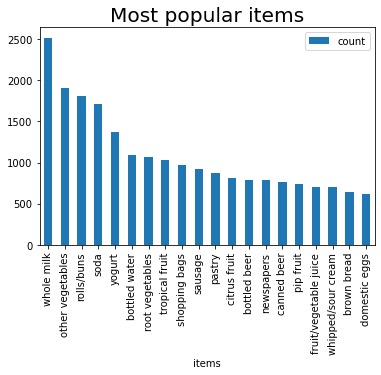

In [20]:
ax = df2.plot.bar(x = 'items', y = 'count')
plt.style.use('fivethirtyeight')
plt.title('Most popular items')
plt.show()

In [22]:
tot_item = sum(df_clean.sum())
df2['Item_percent'] = df2['count']/tot_item
df2['Tot_percent'] = df2.Item_percent.cumsum()
df2.head(20)

,items,count,Item_percent,Tot_percent
0,whole milk,2513,0.058083,0.058083
1,other vegetables,1903,0.043984,0.102066
2,rolls/buns,1808,0.041788,0.143854
3,soda,1713,0.039592,0.183447
4,yogurt,1372,0.031711,0.215157
5,bottled water,1086,0.025101,0.240258
6,root vegetables,1072,0.024777,0.265035
7,tropical fruit,1032,0.023852,0.288887
8,shopping bags,968,0.022373,0.311261
9,sausage,924,0.021356,0.332617


In [25]:
def prune_dataset(olddf, len_transaction, tot_sales_percent):
    # Delete the last column tot_items if present
    if 'tot_items' in olddf.columns:
        del(olddf['tot_items'])
    #Finding the item_count for each item and total number of items.
    #This is the same code as in step 3    
    Item_count = olddf.sum().sort_values(ascending = False).reset_index()
    tot_items = sum(olddf.sum().sort_values(ascending = False))
    Item_count.rename(columns={Item_count.columns[0]:'Item_name',Item_count.columns[1]:'Item_count'}, inplace=True)
    
    # Code from Step 3 to find Item Percentage and Total Percentage.
    Item_count['Item_percent'] = Item_count['Item_count']/tot_items
    Item_count['Tot_percent'] = Item_count.Item_percent.cumsum()
    
    # Taking items that fit the condition/ minimum threshold for total sales percentage.
    selected_items = list(Item_count[Item_count.Tot_percent < tot_sales_percent].Item_name)
    olddf['tot_items'] = olddf[selected_items].sum(axis = 1)
    
    # Taking items that fit the condition/ minimum threshold for length of transaction or number of items in a row.
    olddf = olddf[olddf.tot_items >= len_transaction]
    del(olddf['tot_items'])
    
    #Return pruned dataframe.
    return olddf[selected_items], Item_count[Item_count.Tot_percent < tot_sales_percent]

In [27]:
output_df, item_counts = prune_dataset(df_clean,2,0.4)
print(output_df.shape)
print(list(output_df.columns))

(4585, 13)
['whole milk', 'other vegetables', 'rolls/buns', 'soda', 'yogurt', 'bottled water', 'root vegetables', 'tropical fruit', 'shopping bags', 'sausage', 'pastry', 'citrus fruit', 'bottled beer']


In [28]:
frequent_itemsets = apriori(output_df, min_support=0.01, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.442748,(whole milk),1
1,0.352454,(other vegetables),1
2,0.310796,(rolls/buns),1
3,0.278953,(soda),1
4,0.256052,(yogurt),1
...,...,...,...
218,0.012432,"(citrus fruit, other vegetables, root vegetabl...",4
219,0.010687,"(citrus fruit, other vegetables, tropical frui...",4
220,0.010251,"(yogurt, tropical fruit, rolls/buns, whole milk)",4
221,0.012214,"(yogurt, tropical fruit, root vegetables, whol...",4


In [30]:
frequent_itemsets[ (frequent_itemsets['length'] == 2)]
rules_mlxtend = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules_mlxtend

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(other vegetables),(whole milk),0.352454,0.442748,0.160523,0.455446,1.028679,0.004475,1.023317
1,(whole milk),(other vegetables),0.442748,0.352454,0.160523,0.362562,1.028679,0.004475,1.015857
2,(yogurt),(whole milk),0.256052,0.442748,0.120174,0.469336,1.060051,0.006808,1.050102
3,(whole milk),(yogurt),0.442748,0.256052,0.120174,0.271429,1.060051,0.006808,1.021105
4,(root vegetables),(whole milk),0.207852,0.442748,0.104907,0.504722,1.139975,0.012881,1.125129
...,...,...,...,...,...,...,...,...,...
567,"(tropical fruit, root vegetables)","(yogurt, other vegetables)",0.045147,0.093130,0.010687,0.236715,2.541776,0.006482,1.188115
568,(yogurt),"(tropical fruit, other vegetables, root vegeta...",0.256052,0.026390,0.010687,0.041738,1.581546,0.003930,1.016016
569,(other vegetables),"(yogurt, tropical fruit, root vegetables)",0.352454,0.017448,0.010687,0.030322,1.737817,0.004537,1.013276
570,(tropical fruit),"(yogurt, other vegetables, root vegetables)",0.199346,0.027699,0.010687,0.053611,1.935466,0.005165,1.027379


In [31]:
rules_mlxtend["antecedent_len"] = rules_mlxtend["antecedents"].apply(lambda x: len(x))
rules_mlxtend

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
0,(other vegetables),(whole milk),0.352454,0.442748,0.160523,0.455446,1.028679,0.004475,1.023317,1
1,(whole milk),(other vegetables),0.442748,0.352454,0.160523,0.362562,1.028679,0.004475,1.015857,1
2,(yogurt),(whole milk),0.256052,0.442748,0.120174,0.469336,1.060051,0.006808,1.050102,1
3,(whole milk),(yogurt),0.442748,0.256052,0.120174,0.271429,1.060051,0.006808,1.021105,1
4,(root vegetables),(whole milk),0.207852,0.442748,0.104907,0.504722,1.139975,0.012881,1.125129,1
...,...,...,...,...,...,...,...,...,...,...
567,"(tropical fruit, root vegetables)","(yogurt, other vegetables)",0.045147,0.093130,0.010687,0.236715,2.541776,0.006482,1.188115,2
568,(yogurt),"(tropical fruit, other vegetables, root vegeta...",0.256052,0.026390,0.010687,0.041738,1.581546,0.003930,1.016016,1
569,(other vegetables),"(yogurt, tropical fruit, root vegetables)",0.352454,0.017448,0.010687,0.030322,1.737817,0.004537,1.013276,1
570,(tropical fruit),"(yogurt, other vegetables, root vegetables)",0.199346,0.027699,0.010687,0.053611,1.935466,0.005165,1.027379,1


In [32]:
rules_mlxtend[ (rules_mlxtend['antecedent_len'] >= 2) &
       (rules_mlxtend['confidence'] >= 0.3) &
       (rules_mlxtend['lift'] >= 1) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
48,"(yogurt, other vegetables)",(whole milk),0.093130,0.442748,0.047764,0.512881,1.158403,0.006531,1.143974,2
49,"(yogurt, whole milk)",(other vegetables),0.120174,0.352454,0.047764,0.397459,1.127692,0.005409,1.074693,2
54,"(root vegetables, other vegetables)",(whole milk),0.101636,0.442748,0.049727,0.489270,1.105076,0.004728,1.091090,2
55,"(root vegetables, whole milk)",(other vegetables),0.104907,0.352454,0.049727,0.474012,1.344893,0.012752,1.231106,2
56,"(other vegetables, whole milk)",(root vegetables),0.160523,0.207852,0.049727,0.309783,1.490402,0.016362,1.147679,2
...,...,...,...,...,...,...,...,...,...,...
547,"(tropical fruit, root vegetables, whole milk)",(yogurt),0.025736,0.256052,0.012214,0.474576,1.853435,0.005624,1.415900,3
558,"(yogurt, other vegetables, tropical fruit)",(root vegetables),0.026390,0.207852,0.010687,0.404959,1.948306,0.005202,1.331249,3
559,"(yogurt, other vegetables, root vegetables)",(tropical fruit),0.027699,0.199346,0.010687,0.385827,1.935466,0.005165,1.303629,3
560,"(yogurt, tropical fruit, root vegetables)",(other vegetables),0.017448,0.352454,0.010687,0.612500,1.737817,0.004537,1.671087,3
